<h2> Reduced Basis Methods for the Helmholz Equation </h2>

We want to create a reduced basis space for the Helmholz equation
\begin{equation}
    \Delta u - \omega^2u = f
\end{equation}

and Robin ("absorbing") boundary conditions

$$
\frac{\partial u}{\partial n} + i \omega u = 0 \qquad \text{ on } \partial \Omega
$$

defined on a two dimensional domain $\Omega$. It has the Galerkin formulation in the finite element space $V_h$. Find an $u_h$ so that

\begin{equation}
    \int_{\Omega} \nabla u_h \nabla v_h \text{dx} - \omega^2 \int_{\Omega} u_hv_h \text{dx} - i\omega \int_{\partial \Omega} u_hv_h \text{ds} = \int_{\Omega} fv_h \text{dx}
\end{equation}

holds for all $v_h \in V_h$. We can write this as an equation of bilinearforms 

\begin{equation}
    k(u_h, v_h) - \omega^2 m(u_h, v_h) - i\omega r(u_h,v_h)= \int_{\Omega} fv_h \text{dx}  \tag{1}
\end{equation}

where $r$ only exists if we want Robin boundary conditions, otherwise $r(u,v) \equiv 0$. To get Dirichlet boundaries, we choose our test functions $v$ from the Sobolev space $H_0^1(\Omega)$ and Neumann boundaries are enforced for $v \in H^1(\Omega)$. 


<h3> The reduced basis method </h3>

In a nutshell the idea of creating a reduced basis space is to choose a so called snapshot of $N$ parameters $ \{ \omega_1, .., \omega_N \} $ for which we solve the system $(1)$. By doing so we get linearly independent snapshot solutions $\{u_h^1, .., u_h^N\}$. The space 
\begin{equation}
V_N := \overline{\text{span}\{u_h^1, .., u_h^N\}}
\end{equation}
is a linear subspace of $V_h$. To approximate a solution for an arbitrary $\omega$ we now have to solve the system $(1)$ only for $v_N \in V_N$, which is computationally way less expensive than solving the original system. 

<h3> Generate a Reduced Basis Space </h3>

We first need to import some libraries and then we write a little python class. 

The input parameter for the class is the finite element space and a coefficient function $f$. 

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
from netgen.geom2d import unit_square


import numpy as np
import scipy
import math
import time
import textwrap 

from ngsolve.webgui import Draw

np.random.seed(42)



The `setSpace` and `reset` functions just (re-)set some parameters we will need later. 

In [2]:
class ReducedBasis:
    
    def __init__(self, fes, blf, rhs, snap = None):

        self.logging = True    
        
        self.fes = fes
        
        # set (bi-)linear forms and matrices
        self.omega = Parameter(0)
        u,v = self.fes.TnT()
        self.a = BilinearForm(self.fes)
        keys = ['k', 'r', 'm']
        for j in range(len(keys)):
            if blf[j]:
                self.a += eval('self.omega**j*'+blf[j])
                exec(textwrap.dedent("""
                self.{} = BilinearForm(self.fes)
                self.{} += eval(blf[j])
                self.{}.Assemble()
                """.format(keys[j],keys[j],keys[j])))

        self.a.Assemble()
        
        self.f = LinearForm(self.fes)
        self.f += eval(rhs)
        self.f.Assemble()
                
        # store ainv for better performance
        self.ainv = self.a.mat.Inverse(self.fes.FreeDofs(), inverse="sparsecholesky")

        # initialize grid functions
        self.gfu = GridFunction(self.fes)
        self.drawu = GridFunction(self.fes)

        # temporary ngsolve vectors
        self.__bv_tmp = self.k.mat.CreateColVector()
        self.__bv_tmp2 = self.k.mat.CreateColVector()
        self.__gf_tmp = GridFunction(self.fes)
        
        
        self.proj = Projector(self.fes.FreeDofs(), True)

        # compute norm of f
        self.__bv_tmp.data = self.proj*self.f.vec
        self.f.vec.data = self.__bv_tmp.data
        self.__normf = Norm(self.__bv_tmp)**2
        
        # initialize reduced matrices
        self.k_red = None
        self.m_red = None
        self.r_red = None
        self.addSnapshots(snapshots)

        try:
            self.addSnapshots(snapshots)
        except:
            if self.logging: print("no snapshots given")
            

Next we can create a function that takes a list of omegas and sets them as snapshots. To have the possibility to dynamically expand our reduced basis later on, we will expand the list of snapshot parameters instead of resetting them if `reset==False`. We will also add a get function. 

In [3]:
class ReducedBasis(ReducedBasis):

    def addSnapshots(self, new_snapshots):
        
        # set snapshots and check that they do not already exist
        try:
            new_snapshots = np.unique(new_snapshots)
            new_snapshots = new_snapshots[np.array([s not in self.__snapshots for s in new_snapshots])]
            if self.logging: print("append snapshots with {}".format(new_snapshots))
            self.__snapshots = np.append(self.__snapshots, new_snapshots)
        except:
            if self.logging: print("set snapshots and reset basis")
            self.__snapshots = np.array(new_snapshots)
            self.V = None

        # store smallest and biggest snapshot parameter
        self.omega_min = min(self.__snapshots)
        self.omega_max = max(self.__snapshots)
        
        self.__computeRB()
        
        # only needed in this Jupyter Notebook 
        self.__update_res_mat = True


    def getSnapshots(self):
        return self.__snapshots

Let $n$ be the dimension of the original space $V_h$. The snapshot solutions $\{u_h^1, .., u_h^N\}$ could be used directly as basis functions for $V_N$. However we prefer the matrix $V \in \mathbb{R}^{n\times N} $ that contains the coefficients of the reduced basis functions $\{\zeta^1, .., \zeta^N\}$  to be as pretty as possible. Therefore we make sure that the coefficient vectors of the $\zeta_i$ form an ortonormal system respective the Euklidean norm. This we achieve by performing a QR-decomposition and only using the Q part. 


We now solve the equation $(1)$ in the original space for the new snapshots. If the matrix $V$ already contains some basis functions, we extend the basis. 

In [4]:
class ReducedBasis(ReducedBasis):
    
    def __computeRB(self):

        if self.logging: print("compute Reduced Basis")

        # extend basis if it already exists
        try: 
            existing_basis_len = len(self.V)
            if self.logging: print("extend reduced basis")
        except:
            existing_basis_len = 0

        with TaskManager():

            for n in range(0+existing_basis_len, len(self.__snapshots)):
                omega = self.__snapshots[n]
                
                # compute FEM solution for parameter omega
                self.omega.Set(omega)
                self.a.Assemble()

                self.ainv.Update()
                self.gfu.vec.data = self.ainv * self.f.vec
                
                try:
                    self.V.Append(self.gfu.vec)
                except:
                    self.V = MultiVector(self.gfu.vec, 1)
                    self.V[0] = self.gfu.vec
                    
                ## TODO: AppendOrthogonalize in multivec
                
            # orthognalize
            self.V.GramSchmidt()
        
            # compute matrices in reduced space
            mv = MultiVector(self.gfu.vec, len(self.__snapshots))
            
            self.not_zero = []
            for key in ['k', 'm', 'r']:
                try:
                    mv[0:len(self.__snapshots)] = eval('self.{}.mat * self.V'.format(key))
                    exec('self.{}_red = InnerProduct(self.V, mv)'.format(key))
                    self.not_zero += [key]
                except:
                    exec('self.{}_red = Matrix(len(self.V), len(self.V), self.fes.is_complex)'.format(key))
                    exec('self.{}_red[:] = 0'.format(key))

            mv = MultiVector(self.f.vec, 1)
            mv[0] = self.f.vec
            self.f_red = InnerProduct(self.V, mv)
            
            
            if self.logging: print("finished computing Reduced Basis")
            

To look at the solutions of the reduced system, we want to implement a draw function, that takes a parameter $\omega$, computes the reduced solution and displays it in the ngsolve webgui.

In [5]:

class ReducedBasis(ReducedBasis):
    
    def draw(self, omega, redraw=False):
        
        # compute reduced solution

        ## TODO: updatable a_red.inv (Base Matrix instead of bla-Matrix?) and omega as parameter
        A = self.k_red+self.m_red*omega*omega+self.r_red*omega
        v = A.I * self.f_red
        
        self.drawu.vec.data = self.V * v[:,0]
        
        if self.logging: print("omega: {}, norm of solution: {}".format(omega, np.real(Integrate ( Conj(self.drawu)*(self.drawu), self.fes.mesh))))
        
        # draw solution
        if not redraw:
            self.scene = Draw(self.drawu)
        else:
            self.scene.Redraw()


To test the implementation so far, we define an H1-FEM space on the unit square with Dirichlet boundary values on the bottom and right. To compute the first set of snapshot solutions we choose the parameters $\omega \in \{0, .., 10\}$. Subsequently we create a slider to visualize the reduced solutions for a set of omegas. 

In [6]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
fes = H1(mesh, order=3, dirichlet="bottom|right", complex=True)

x_0 = 0.6
y_0 = 0.3
func = '100*exp(-20*((x-x_0)**2 + (y-y_0)**2))'
snapshots = np.arange(1,11, 1)

space = ReducedBasis(fes = fes, blf = ['grad(u)*grad(v)*dx', None, '-u*v *dx'], rhs=func+'*v*dx', snap=snapshots)

slider_func = lambda x: space.draw(x, redraw=True)
space.draw(space.omega_min)

interact(slider_func, x=widgets.FloatSlider(min=space.omega_min, max=space.omega_max, step=0.05, value=space.omega_min))

grad(u)*grad(v)*dx
self.omega*self.omega*-u*v *dx
set snapshots and reset basis
compute Reduced Basis
finished computing Reduced Basis
append snapshots with []
compute Reduced Basis
extend reduced basis
finished computing Reduced Basis
omega: 1, norm of solution: 4.751257782884012


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2006-102-g6b22c0d70', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2…

interactive(children=(FloatSlider(value=1.0, description='x', max=10.0, min=1.0, step=0.05), Output()), _dom_c…

<function __main__.<lambda>(x)>

<h3> Compute the residual </h3>

Let $M, K, R \in \mathbb{C}^{nxn}$ and $F \in \mathbb{C}^{n}$ be the matrices (respectively the vector) corresponding to the bilinear forms in (1). A solution of the reduced system can be written as $Vu = \sum_{j = 1}^{N}u_j\zeta_j \in V_h$ with coefficient vector $u = (u_1, .., u_N)$. Therefore a norm of the residual can be defined as $|| (K-\omega^2 M -i\omega R)Vu -F||$.


By squaring and rearranging the therm above we get an expression for the residual

\begin{equation}
\begin{split}
    \text{res}(\omega) :&= || (K-\omega^2 M -i\omega R)Vu -F||_2^2 \\
    &= || (K-\omega^2 M -i\omega R)Vu||_2^2 - 2\text{Re} \langle (K-\omega^2 M -i\omega R)Vu , F \rangle + ||F||_2^2 \\
    &= \sum_{j = 1}^N \sum_{k = 1}^N u_j \overline{u_k}\langle (K-\omega^2 M -i\omega R)\zeta_j, (K-\omega^2 M -i\omega R)\zeta_k \rangle - 2\text{Re}\sum_{j = 1}^N u_j \langle (K-\omega^2 M -i\omega R)\zeta_j, F \rangle  + || F||^2 \\
    & = \overline{u^T}Au - 2\text{Re} A_F u + || F||^2
\end{split} 
\end{equation}
where 
\begin{equation}
\begin{split}
    (A)_{jk} = ~ & \langle K\zeta_j, K\zeta_k \rangle -\omega^2 \langle M\zeta_j, K\zeta_k \rangle - i\omega \langle R\zeta_j, K\zeta_k \rangle \\
       & - \omega^2 \langle K\zeta_j, M\zeta_k \rangle + \omega^4 \langle M\zeta_j, M\zeta_k \rangle + i\omega^3 \langle R\zeta_j, M\zeta_k \rangle \\
       &-i\omega \langle K\zeta_j, R\zeta_k \rangle + i \omega^3 \langle M\zeta_j, R\zeta_k \rangle - \omega^2 \langle R\zeta_j, R\zeta_k \rangle.
\end{split}
\end{equation}
and 
\begin{equation}
    (A_F)_{j} = \langle K\zeta_j, F \rangle - \omega^2 \langle M\zeta_j, F \rangle - i\omega \langle R\zeta_j, F \rangle.
\end{equation}

Now we can implement a function that build all the necessary matrices. 

We now want to plot the norms and residuals of the solutions for a large set of different omegas. Therefore we extend our class by a function that takes a vector of omegas and returns the corresponding values (norm and/or residual).

In [7]:
class ReducedBasis(ReducedBasis):

    def __computeResMat(self):

        self.__update_res_mat = False
        dim = eval('(self.{}_red.h, self.{}_red.w)'.format(self.not_zero[0], self.not_zero[0]))
        bv_tmp = self.__bv_tmp # needed to be able to use exec(''' .. ''')
        tmp = MultiVector(self.__bv_tmp, dim[0])
        keys = []

        for i in range(len(self.not_zero)):
            # set multivectors
            exec(textwrap.dedent('''
            {}_zeta = MultiVector(bv_tmp, dim[0])
            tmp.data = self.{}.mat * self.V
            {}_zeta.data = self.proj * tmp
            '''.format(self.not_zero[i], self.not_zero[i], self.not_zero[i])))
            # set keys
            for k in range(i, len(self.not_zero)):
                keys += [self.not_zero[i]+self.not_zero[k]]
                
        self.__res_mat = {} # available keys: 'kk', 'km', 'kr', 'mm', 'mr', 'rr'

        # calculate scalar products
        for key in keys:
            self.__res_mat[key] = eval(
                "InnerProduct ({}_zeta, {}_zeta)".format(list(key)[0], list(key)[1]))
            # calculate inner products with right hand side
            if list(key)[0] == list(key)[1]:
                self.__res_mat['{}f'.format(list(key)[0])] = Vector(dim[0], self.fes.is_complex)
                for j in range(dim[0]): 
                    self.__res_mat['{}f'.format(list(key)[0])][j] = eval(
                        "InnerProduct ({}_zeta[{}], self.f.vec.data)".format(list(key)[0], j))
                    
        # set other matrices to zero
        for key in ['kk', 'km', 'kr', 'mm', 'mr', 'rr']:
            if key not in keys:
                self.__res_mat[key] = Matrix(dim[0], dim[1], self.fes.is_complex)
                self.__res_mat[key][:] = 0
                
        for key in ['k', 'm', 'r']:
            if key not in self.not_zero:
                self.__res_mat['{}f'.format(key)] = Vector(dim[0], self.fes.is_complex)


In [8]:
class ReducedBasis(ReducedBasis):
    
    def computeValues(self, param, residual=True, norm=True, cheap = True):
        
        if residual and norm: 
            if self.logging: print("compute residual and norm")
        elif residual: 
            if self.logging: print("compute residual")
        elif norm: 
            if self.logging: print("compute norm")
        else: return
        
        norm_ret = []
        residual_ret = []
        # needed only in this jupyter notebook
        if self.__update_res_mat:
            self.__computeResMat()
        self.__update_res_mat = False

        
        with TaskManager():

            for omega in param:

                # compute reduced solution
                A = self.k_red+self.m_red*omega*omega+self.r_red*omega
                v = A.I * self.f_red
                red_sol_vec = v[:,0]
            
                if norm:

                    self.__gf_tmp.vec.data = self.V * red_sol_vec
                    # imaginary part is not exactly 0 due to numerical errors
                    nof = np.real(Integrate(self.__gf_tmp*Conj(self.__gf_tmp), self.fes.mesh))
                    norm_ret += [nof]

                if residual:   
                    
                    if cheap:
                        
                        if self.__update_res_mat:
                            self.__computeResMat()
                            
                        ## TODO: wrapper for ".C" for real matrices
                        if self.fes.is_complex: 
    
                            A = (self.__res_mat['kk']+(self.__res_mat['km']+
                                self.__res_mat['km'].C)*omega**2+ self.__res_mat['mm']*omega**4 +
                                (self.__res_mat['kr']+self.__res_mat['kr'].C)*-1j*omega
                                 + (self.__res_mat['mr']+self.__res_mat['mr'].C) * 1j*omega**3
                                 + self.__res_mat['rr'] * 1j*omega**2)

                        else:
                            A = (self.__res_mat['kk']+ self.__res_mat['km']*omega**2*2+self.__res_mat['mm']*omega**4)
                            
                        A_F = self.__res_mat['kf']+self.__res_mat['mf']*omega**2+self.__res_mat['rf'] *omega
    
                            
                        res = InnerProduct(red_sol_vec, A * red_sol_vec) - 2*np.real( InnerProduct(red_sol_vec, A_F)) + self.__normf
                        residual_ret += [abs(res)]

                    else:
                        
                        if not norm: self.__gf_tmp.vec.data = self.V * red_sol_vec
                        self.omega.Set(omega)
                        self.a.Assemble()
                        self.__bv_tmp.data = self.a.mat*self.__gf_tmp.vec - self.f.vec
                        self.__bv_tmp2.data = self.proj*self.__bv_tmp
                        res = Norm(self.__bv_tmp2)**2
                    
                        residual_ret += [res]
                    
                    
        if self.logging: print("finished computing values")
        if norm and (not residual): return norm_ret
        if residual and (not norm): return residual_ret
        if norm and residual: return norm_ret, residual_ret
    

Again we define an instance of our now updated class. Afterwards we can plot norm and residuals for a set of random omegas. 

In [9]:
space = ReducedBasis(fes, ['grad(u)*grad(v)*dx', '-1j*u*v*ds', '-u*v *dx'], func+'*v*dx', snapshots)

random_omegas = np.sort(np.append(np.random.uniform(space.omega_min, space.omega_max, 1000), snapshots))
norm_random_omegas, residual_random_omegas = space.computeValues(random_omegas, cheap= False)

slider_func = lambda x: space.draw(x, redraw=True)
space.draw(space.omega_min)

interact(slider_func, x=widgets.FloatSlider(min=space.omega_min, max=space.omega_max, step=0.05, value=space.omega_min))

grad(u)*grad(v)*dx
self.omega*-1j*u*v*ds
self.omega*self.omega*-u*v *dx
set snapshots and reset basis
compute Reduced Basis
finished computing Reduced Basis
append snapshots with []
compute Reduced Basis
extend reduced basis
finished computing Reduced Basis
compute residual and norm
finished computing values
omega: 1, norm of solution: 2.7968961509500643


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2006-102-g6b22c0d70', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2…

interactive(children=(FloatSlider(value=1.0, description='x', max=10.0, min=1.0, step=0.05), Output()), _dom_c…

<function __main__.<lambda>(x)>

<IPython.core.display.Javascript object>


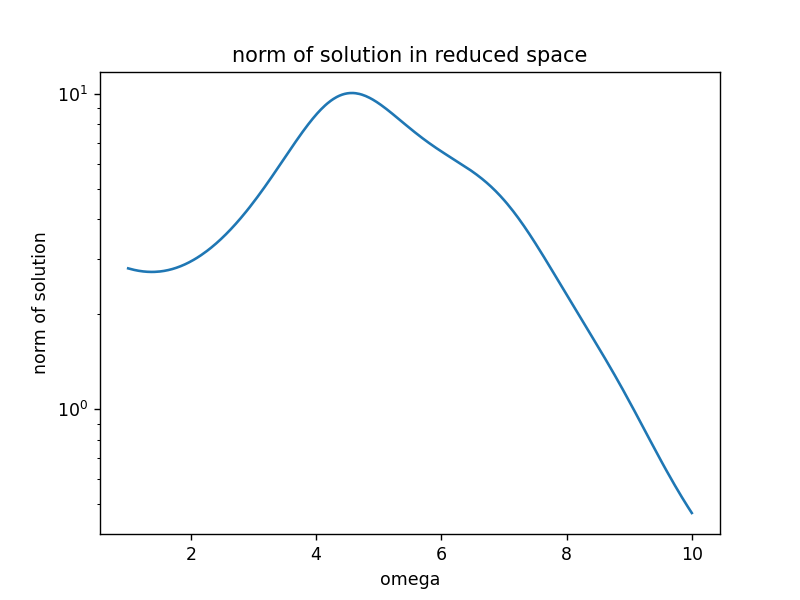

<IPython.core.display.Javascript object>


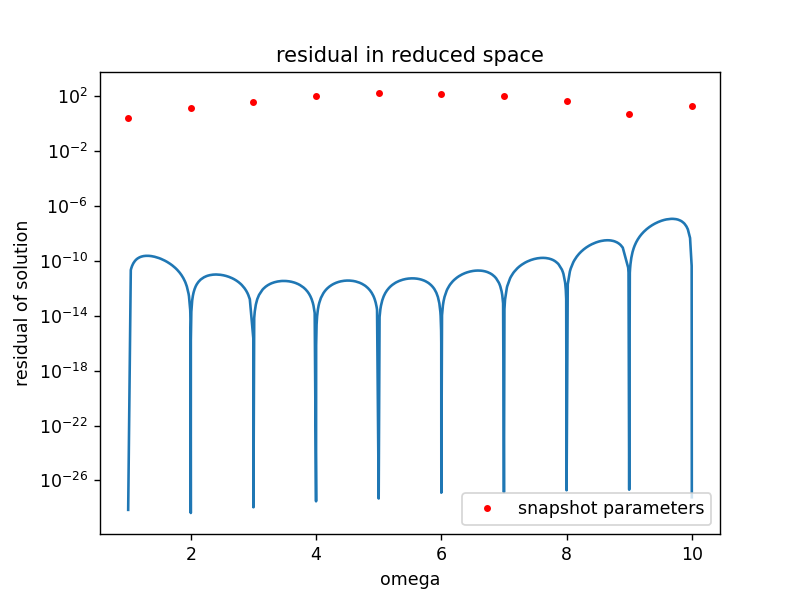

compute residual
finished computing values


[]

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(random_omegas, residual_random_omegas , '-')
residual = space.computeValues(space.getSnapshots(), norm = False)
ax.plot(space.getSnapshots(), residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()

Let $M \in \mathbb{R}^{N\times N}$ and $K \in \mathbb{R}^{N\times N}$ be the corresponding matrices for problem $(1)$ in the reduced space. We choose our `space` to be real valued, so the Eigenvalues $\lambda $ of
\begin{equation}
    \lambda Mx = Kx.
\end{equation}
are real valued and positive. Therefore we can easily compute them und compare $\sqrt{\lambda}$ to the positions of the peaks visible in the plot of the norm. We see that they align as expected.

<IPython.core.display.Javascript object>


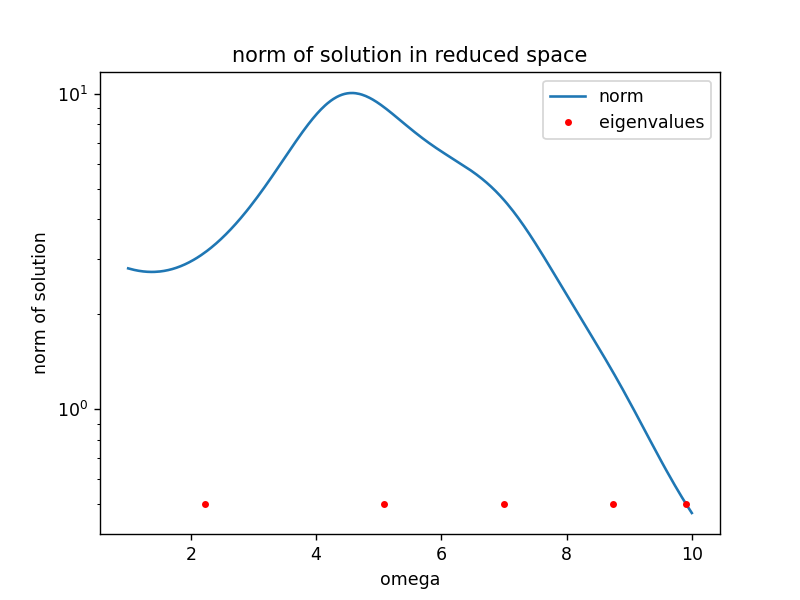

[]

In [11]:
eig = np.sqrt(scipy.linalg.eigh(space.k_red,-space.m_red, eigvals_only=True))
eig = eig[eig <= space.omega_max]

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.plot(eig, 1/2*np.ones(len(eig)), 'r.', label= "eigenvalues")
ax.legend()

ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()


Now we define a space with Robin boundaries and plot norm and residual.

In [12]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
cfes = H1(mesh, order=3, complex=True)

x_0 = 0.6
y_0 = 0.3
func = 100*exp(-20*((x-x_0)**2 + (y-y_0)**2))

cspace = ReducedBasis(cfes, func)
csnapshots = np.arange(1,11, 1)#*(-1)
cspace.setSnapshots(csnapshots)

slider_func = lambda x: cspace.draw(x, redraw=True)
cspace.draw(cspace.omega_min)

interact(slider_func, x=widgets.FloatSlider(min=cspace.omega_min, max=cspace.omega_max, step=0.05, value=cspace.omega_min))

# slider_func = lambda x: cspace.draw(-x, redraw=True)
# cspace.draw(cspace.omega_max)

# interact(slider_func, x=widgets.FloatSlider(min=-cspace.omega_max, max=-cspace.omega_min, step=0.05, value=-cspace.omega_max))

TypeError: __init__() missing 1 required positional argument: 'rhs'

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

crandom_omegas = np.sort(np.append(np.random.uniform(cspace.omega_min, cspace.omega_max, 1000), csnapshots))

cnorm_random_omegas, cresidual_random_omegas = cspace.computeValues(crandom_omegas, cheap = False)

fig, ax = plt.subplots()
ax.plot(crandom_omegas, cnorm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(crandom_omegas, cresidual_random_omegas , '-')
residual = cspace.computeValues(cspace.getSnapshots(), norm = False, cheap= False)
ax.plot(cspace.getSnapshots(), residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()